# Imports

In [1]:
import numpy as np
from unicodedata import normalize
from pprint import pprint
import string
import re
import matplotlib.pyplot as plt
from keras.backend import clear_session
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, CuDNNLSTM, Input, Embedding, TimeDistributed, Flatten, Dropout, RepeatVector
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import load_model

Using TensorFlow backend.


# Reading movie lines

In [2]:
table = str.maketrans('', '', string.punctuation)
# prepare regex for char filtering
re_print = re.compile('[^%s]' % re.escape(string.printable))
# prepare translation table for removing punctuation
table = str.maketrans('', '', string.punctuation)

def clean_sentence(line):
    line = line.strip().replace('--', '').replace("  ", " ").replace('"', "")
    line = normalize('NFD', line).encode('ascii', 'ignore')
    line = line.decode('UTF-8')
    # tokenize on white space
    line = line.split()
    # convert to lowercase
    line = [word.lower() for word in line]
    # remove punctuation from each token
    line = [word.translate(table) for word in line]
    # remove non-printable chars form each token
    line = [re_print.sub('', w) for w in line]
    # remove tokens with numbers in them
    line = [word for word in line if word.isalpha()]
    return ' '.join(line)

with open('./cornell-movie-dialogs-corpus/movie_lines.txt', 'r', errors='ignore') as f:
    lines_as_list = [row.strip() for row in f.readlines()]


lines = {}
for line in lines_as_list:
    lines[
        line.split('+++$+++')[0].strip()
    ] = clean_sentence(line.split('+++$+++')[-1])  # clean sentences

del lines_as_list

with open('./cornell-movie-dialogs-corpus/movie_conversations.txt', 'r', errors='ignore') as f:
    conversations = [row.strip() for row in f.readlines()]

# only take id's and convert list as string to list as list
conversations = [
    conversation.split('+++$+++')[-1].strip().replace('[', '').replace(']', '').replace("'", '').replace(" ", '').split(',') 
    for conversation in conversations
]

pprint({k: lines[k] for k in list(lines)[:10]})
print()
pprint(conversations[:10])

assert len([conversation for conversation in conversations if len(conversation) <=1]) == 0


{'L1044': 'they do to',
 'L1045': 'they do not',
 'L869': 'like my fear of wearing pastels',
 'L870': 'im kidding you know how sometimes you just become this persona and '
         'you dont know how to quit',
 'L871': 'no',
 'L872': 'okay youre gonna need to learn how to lie',
 'L924': 'wow',
 'L925': 'lets go',
 'L984': 'she okay',
 'L985': 'i hope so'}

[['L194', 'L195', 'L196', 'L197'],
 ['L198', 'L199'],
 ['L200', 'L201', 'L202', 'L203'],
 ['L204', 'L205', 'L206'],
 ['L207', 'L208'],
 ['L271', 'L272', 'L273', 'L274', 'L275'],
 ['L276', 'L277'],
 ['L280', 'L281'],
 ['L363', 'L364'],
 ['L365', 'L366']]


# map keys to line

In [3]:
conversations_with_lines = []
for conversation in conversations:
    conversations_with_lines.append([lines[key] for key in conversation])
    
pprint(conversations_with_lines[100:110])

[['yeah', 'what do you think'],
 ['two legs nice rack',
  'yeah whatever i want you to go out with her',
  'sure sparky ill get right on it',
  'you just said',
  'you need money to take a girl out',
  'but youd go out with her if you had the cake'],
 ['you got it verona i pick up the tab you do the honors',
  'youre gonna pay me to take out some girl',
  'i cant date her sister until that one gets a boyfriend and thats the catch '
  'she doesnt want a boyfriend',
  'how much'],
 ['i cant take a girl like that out on twenty bucks', 'fine thirty'],
 ['take it or leave it this isnt a negotiation',
  'fifty and youve got your man'],
 ['when i shell out fifty i expect results',
  'im on it',
  'watching the bitch trash my car doesnt count as a date',
  'i got her under control she just acts crazed in public to keep up the '
  'image'],
 ['i just upped my price',
  'what',
  'a hundred bucks a date',
  'forget it',
  'forget her sister then'],
 ['its about time', 'a deals a deal'],
 ['howd 

# Pair those things

In [4]:
def pair_it(my_list):
    pairs = []
    for i in range(len(my_list) -1):
        pairs.append([my_list[i], my_list[i + 1]])
    return pairs

paired_conversations_agg = [
    pair_it(conversation) for conversation in conversations_with_lines
]
conversations_pairs = np.array([item for sublist in paired_conversations_agg for item in sublist])
for i in range(10):
    pprint(conversations_pairs[i])

array(['can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again',
       'well i thought wed start with pronunciation if thats okay with you'],
      dtype='<U2857')
array(['well i thought wed start with pronunciation if thats okay with you',
       'not the hacking and gagging and spitting part please'],
      dtype='<U2857')
array(['not the hacking and gagging and spitting part please',
       'okay then how bout we try out some french cuisine saturday night'],
      dtype='<U2857')
array(['youre asking me out thats so cute whats your name again',
       'forget it'], dtype='<U2857')
array(['no no its my fault we didnt have a proper introduction',
       'cameron'], dtype='<U2857')
array(['cameron',
       'the thing is cameron im at the mercy of a particularly hideous breed of loser my sister i cant date until she does'],
      dtype='<U2857')
array(['the thing is cameron im at the mercy of a particularly hideou

# Noise reduction

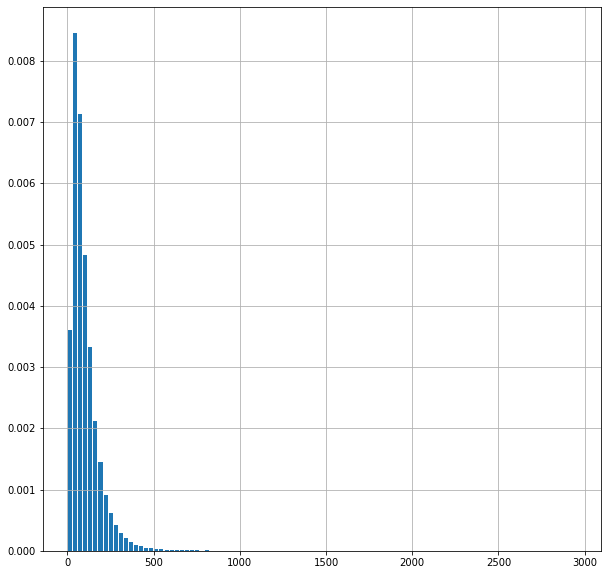

longest conversation: 
['the food and drug administration said wednesday female deodorant sprays may cause such harmful reactions as blisters burns and rashes although the fda judges that the reported reactions are not sufficient to justify removal of these products from the market they are sufficient to warrant the proposed mandatory label warnings'
 'shit o dear thats enough to make me asthmatic the nerve of those twits what do they know about female odor dont interrupt heres my concept my ranch out west its a beauty ranch oh its got a few head of cattle for atmosphere and tax purposes but its a beauty ranch a place where unhappy women divorcees and widows mainly can go to lose weight remove wrinkles change their hair styles and pretty themselves up for the next disappointment my ranch is named the rubber rose after the rubber rose douche bag my own invention and bless its little red bladder the most popular douche bag in the world so get this its on the migratory flight path of the 

In [5]:
hist, edges = np.histogram([len(question) + len(answer) for question, answer in conversations_pairs], density=True, bins=100)
center = (edges[:-1] + edges[1:]) / 2
f, ax = plt.subplots(figsize=(10, 10))
plt.bar(center, hist, align='center', width=(edges[1] - edges[0]) * .8)
plt.grid()
plt.show()

longest_converastion = conversations_pairs[np.array([len(question) + len(answer) for question, answer in conversations_pairs]).argmax()]
print("longest conversation: \n{}".format(longest_converastion))
print("\nlongest conversation lenght: {}".format(len(longest_converastion[0]) + len(longest_converastion[1])))
max_conversation_lenght = 400  # maximum alowed converastion lenght in characters
clensed_conversations = np.array([conversation_pair for conversation_pair in conversations_pairs if len(conversation_pair[0]) + len(conversation_pair[1]) < max_conversation_lenght])
print("filetered {} conversations".format(len(conversations_pairs) - len(clensed_conversations)))

# Shity magic

In [6]:
input_characters = set()

for input_text, target_text in clensed_conversations:
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in input_characters:
            input_characters.add(char)
            
input_characters = sorted(list(input_characters))
# target_characters = sorted(list(target_characters))
num_tokens = len(input_characters)
# num_target_tokens = len(target_characters)
max_input_seq_length = max([len(input_text) for input_text, target_text in clensed_conversations])
max_target_seq_length = max([len(target_text) for input_text, target_text in clensed_conversations])
max_sentence_lenght = max(max_input_seq_length, max_target_seq_length)

print('Number of unique input tokens:', num_tokens)
print('Max sequence length for inputs:', max_input_seq_length)
print('Max sequence length for outputs:', max_target_seq_length)

token_index = dict([(char, i) for i, char in enumerate(input_characters)])

split_index = int(len(clensed_conversations) * .8)
pre_trainX = clensed_conversations[:split_index, 0]
pre_trainY = clensed_conversations[:split_index, 1]
pre_testX = clensed_conversations[split_index:, 0]
pre_testY = clensed_conversations[split_index:, 1]

trainX = np.zeros((len(pre_trainX), max_sentence_lenght), dtype='float32')
trainY = np.zeros((len(pre_trainY), max_sentence_lenght, num_tokens), dtype='float32')
testX = np.zeros((len(pre_testX), max_sentence_lenght), dtype='float32')
testY = np.zeros((len(pre_testY), max_sentence_lenght, num_tokens), dtype='float32')

print("trainX {} | trainY {} | testX {} | testY {}".format(trainX.shape, trainY.shape, testX.shape, testY.shape))

for i, (input_text) in enumerate(pre_trainX):
    for t, char in enumerate(input_text):
        trainX[i, t] = token_index[char]

for i, (target_text) in enumerate(pre_trainY):
    for t, char in enumerate(target_text):
        trainY[i, t, token_index[char]] = 1.

for i, (input_text) in enumerate(pre_testX):
    for t, char in enumerate(input_text):
        testX[i, t] = token_index[char]

for i, (target_text) in enumerate(pre_testY):
    for t, char in enumerate(target_text):
        testY[i, t, token_index[char]] = 1.
        
print(input_characters)

Number of unique input tokens: 27
Max sequence length for inputs: 397
Max sequence length for outputs: 396
trainX (175314, 397) | trainY (175314, 397, 27) | testX (43829, 397) | testY (43829, 397, 27)
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


# Define Model

In [7]:
clear_session()
n_units=256
model = Sequential()
model.add(Embedding(num_tokens, n_units, input_length=max_sentence_lenght, mask_zero=True))
model.add(LSTM(n_units))  # CuDNNLSTM
model.add(RepeatVector(max_sentence_lenght))
model.add(LSTM(n_units, return_sequences=True))  # CuDNNLSTM
model.add(TimeDistributed(Dense(num_tokens, activation='softmax')))

model.compile(optimizer='adam', loss='categorical_crossentropy')
# summarize defined model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 397, 256)          6912      
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 397, 256)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 397, 256)          525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 397, 27)           6939      
Total params: 1,064,475
Trainable params: 1,064,475
Non-trainable params: 0
_________________________________________________________________


# Training

In [ ]:
# fit model
filename = 'mount-this/model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=1)

In [8]:
model = load_model('chatbot-seq-400.h5')

In [20]:
to_infer = 'how are you'
source = np.zeros(max_sentence_lenght)

for i in range(len(to_infer)):
    source[i] = token_index[to_infer[i]]
source = source.reshape((1, source.shape[0]))
res = model.predict(source)
sentence = "".join([input_characters[np.argmax(char_indxes)] for char_indxes in res[0]])
print(to_infer + " -> " + sentence.strip())

how are you -> fi e
